In [1]:
#Importing the libraries 

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import isnan, when, count, col, lit
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import MinMaxScaler, StandardScaler

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Transfer insurance file to hadoop:

! hdfs dfs -put /user/ashok/insurance.csv hdfs://localhost:9000/user/ashok

In [3]:
#Displaying multiple command outputs from a cell  
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
#Creating a Session
spark = SparkSession.builder.master("insurance").getOrCreate()

In [5]:
# Read Data
data = spark.read.csv(
                    path = "hdfs://localhost:9000/user/ashok/insurance.csv",
                    inferSchema = True,
                    header = True
                   )

## Data Exploration

In [5]:
#Viewing the coulums available
data.columns

#Viewing the number of rows
data.count()

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

1338

In [6]:
#Viewing the statistics of the data
data.describe().toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
age,1338,39.20702541106129,14.049960379216147,18,64
sex,1338,None,None,female,male
bmi,1338,30.663396860986538,6.098186911679012,15.96,53.13
children,1338,1.0949177877429,1.205492739781914,0,5
smoker,1338,None,None,no,yes
region,1338,None,None,northeast,southwest
charges,1338,13270.422265141257,12110.011236693992,1121.8739,63770.42801


In [7]:
# Viewing all the data
data.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [8]:
# Check For Missing Values
data.toPandas().isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
#Checking the Schema of the data
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [10]:
#Grouping the data by sex
data.groupby('sex').count().show()

#It can be seen that the data is balanced in terms of the sex

+------+-----+
|   sex|count|
+------+-----+
|female|  662|
|  male|  676|
+------+-----+



In [11]:
#Grouping the data by region
data.groupby('region').count().show()

#It can be seen that the data is almost evenly distributed across the regions

+---------+-----+
|   region|count|
+---------+-----+
|northwest|  325|
|southeast|  364|
|northeast|  324|
|southwest|  325|
+---------+-----+



In [12]:
#Converting the data to panda dataframe
data_panda=data.toPandas()

In [13]:
data_panda.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<Figure size 1296x576 with 0 Axes>

Text(0.5, 1.0, 'Age vs Charges')

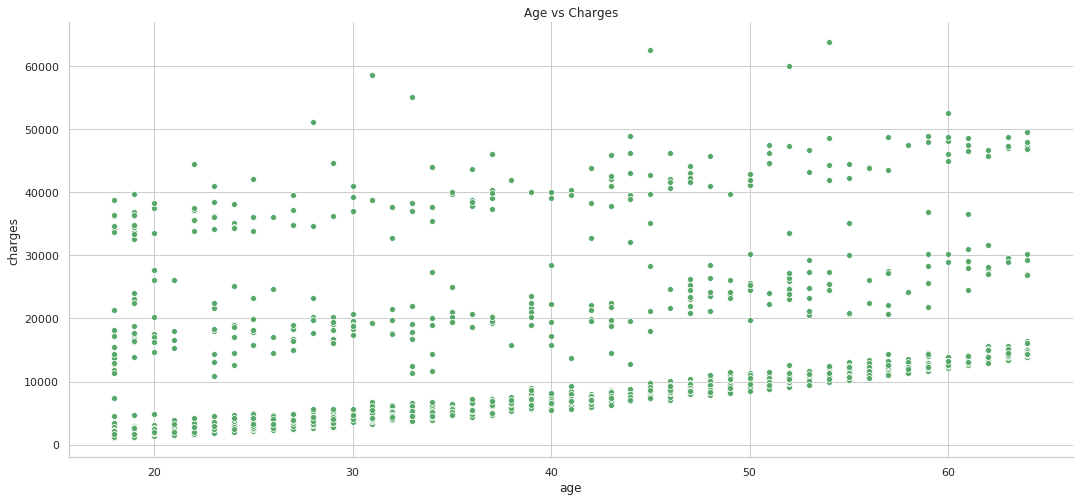

In [18]:
#Plotting a scatter plot between Age & Charges 
plt.figure(figsize = (18, 8))
sns.set(style="whitegrid")
sns.scatterplot(x= data_panda['age'] , y= data_panda['charges'], color = 'g')
plt.title("Age vs Charges")
sns.despine()

It can be seen that there are 3 distinct group of members : low-cost, medium-cost and high-cost members.

<Figure size 1296x576 with 0 Axes>

Text(0.5, 1.0, 'Age vs Charges')

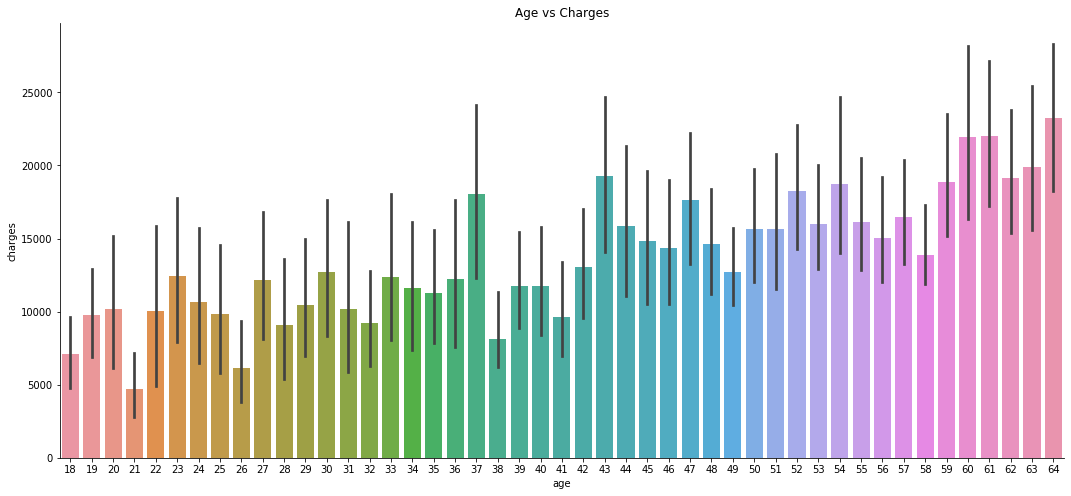

In [16]:
#Plotting a graph for Age & Charges
plt.figure(figsize = (18, 8))
sns.barplot(x = 'age', y = 'charges', data = data_panda)
plt.title("Age vs Charges")
sns.despine()

It can be seen that charges go up with age and there is a spike at ages like 22 and 27. 
Probably because people start earning at this age and are forced to buy their insurance plan

<Figure size 1296x576 with 0 Axes>

Text(0.5, 1.0, 'Children vs Charges')

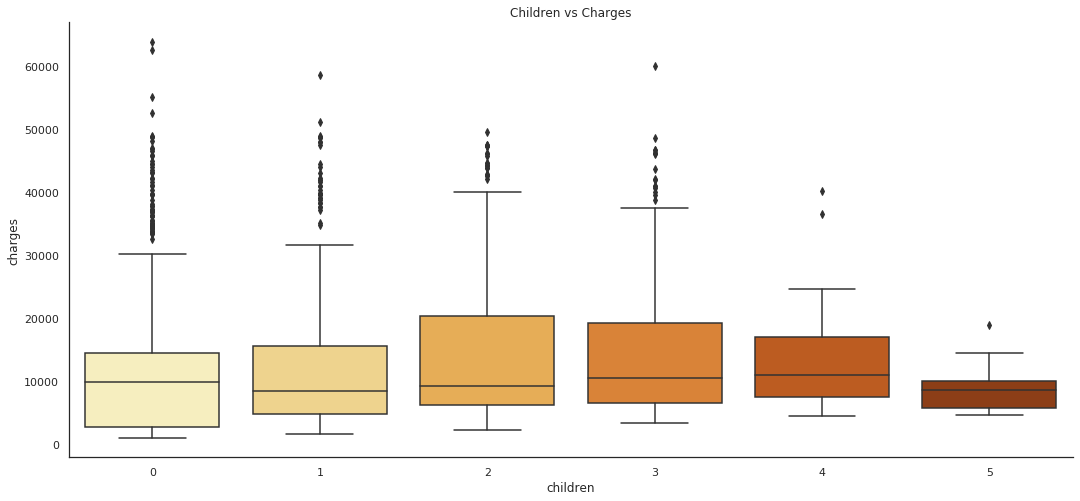

In [19]:
#Plotting relationship between number of childeren and Charges

sns.set_style("white")
plt.figure(figsize = (18, 8))
sns.boxplot(x = 'children', y = 'charges', data = data_panda, palette ='YlOrBr')
plt.title('Children vs Charges')
sns.despine()

It can be observed that the number of children impacts the charges.
The members with 2 or 3 kids have slightly higher charges than those with 0-1 or 4-5 kids. 

<Figure size 1296x432 with 0 Axes>

Text(0.5, 1.0, 'Charges vs Age Filtered by Sex')

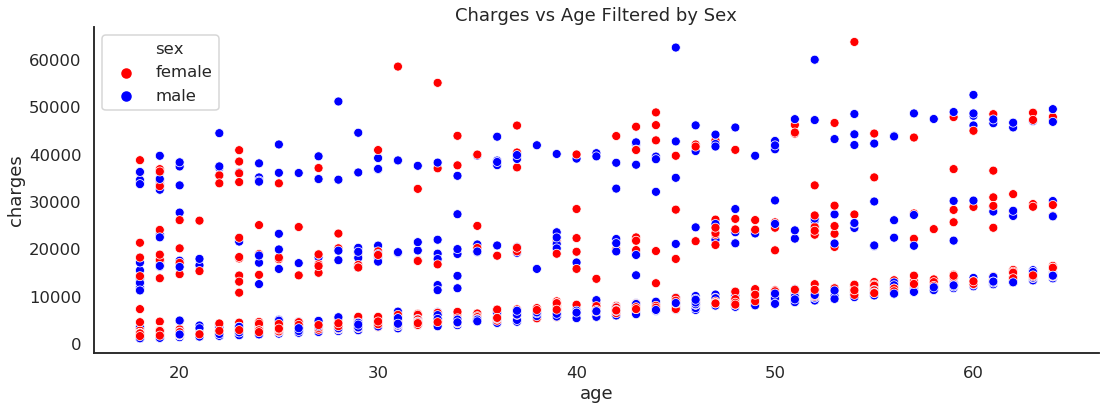

In [24]:
#Plotting a scatter plot of Charges vs Age Filtered by Sex
sns.set_context('talk')
sns.set_style("white")
plt.figure(figsize = (18, 6))
colors = ['red', 'blue']
sns.scatterplot(x='age' , y='charges', hue='sex', palette = colors, data=data_panda).set_title('Charges vs Age Filtered by Sex')
sns.despine()

 It can be seen that in general, the males population have a greater number of high cost charges than females.

<Figure size 1296x432 with 0 Axes>

Text(0.5, 1.0, 'Charges vs Age Filtered by Smoking Status')

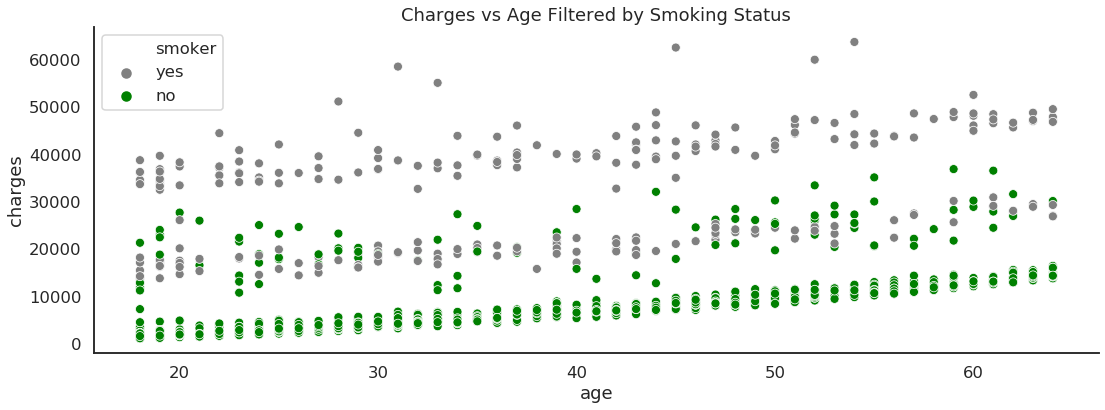

In [23]:
#Plotting a scatter plot of Charges vs Age Filtered by Smoking Status

colors = ['gray', 'green']
plt.figure(figsize = (18, 6))
sns.scatterplot(x= 'age' , y= 'charges', hue='smoker', palette = colors, data=data_panda).set_title('Charges vs Age Filtered by Smoking Status')
sns.despine()

Smokers consistently have higher charges on average than non-smokers, independent of age. 

## Pipeline creation

In [29]:
#Selecting all categorical columns
cat_cols=[c[0] for c in data.dtypes if c[1]=="string"]

In [30]:
#The following are the categorical columns
cat_cols

['sex', 'smoker', 'region']

In [31]:
#Selecting all numerical columns
num_cols=[c[0] for c in data.dtypes if c[1]!="string"]
num_cols

['age', 'bmi', 'children', 'charges']

In [32]:
#Creating one hot encoder columns
ohe_cols=[c+"_ohe" for c in cat_cols]
ohe_cols

['sex_ohe', 'smoker_ohe', 'region_ohe']

In [33]:
cat_cols_si= [c+"_index" for c in cat_cols]
print (cat_cols_si)

['sex_index', 'smoker_index', 'region_index']


In [34]:
cat_cols_ohe= [c+"_ohe" for c in cat_cols]
print (cat_cols_ohe)

['sex_ohe', 'smoker_ohe', 'region_ohe']


In [35]:
## Pipeline
pipe = Pipeline(
                stages=[
                    StringIndexer(
                        inputCols=cat_cols,
                        outputCols=cat_cols_si
                    ),
                    OneHotEncoder(
                        inputCols=cat_cols_si,
                        outputCols=ohe_cols
                    ),
                    VectorAssembler(
                        inputCols=cat_cols_si+num_cols,
                        outputCol="all_features"
                    ),
                    StandardScaler(
                        inputCol="all_features",
                        outputCol="features"
                    )
                ]
    )

## Model Building

In [36]:
#Splitting of traing and test data
train_data, test_data = data.randomSplit([0.8,0.2], seed=123)

### Random Forest Regressor

In [23]:
rf = RandomForestRegressor(featuresCol = "features", labelCol="charges")
pipeline_rf = Pipeline(stages=[pipe, rf])

In [24]:
#Saving the pipeline
pipeline_rf.write().overwrite().save("pipeline_rf")

In [25]:
#Creating a cross validator for hyperparameter tuning

In [26]:
pipelineModel_rf = Pipeline.load("pipeline_rf")

In [27]:
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.maxDepth, [2, 5, 10])
                .addGrid(rf.maxBins, [5, 10, 20])
                .addGrid(rf.numTrees, [5, 20, 50])
             .build())


In [28]:
crossval_rf = CrossValidator(estimator=pipelineModel_rf,
                          estimatorParamMaps = paramGrid_rf,
                          evaluator= RegressionEvaluator(labelCol = "charges"),
                          numFolds=5)

In [29]:
#Training and prediction

In [30]:
cvModel_rf= crossval_rf.fit(train_data)

In [31]:
bestModel_rf= cvModel_rf.bestModel
for x in range(len(bestModel_rf.stages)):
    print(bestModel_rf.stages[x])

PipelineModel_59156db4dbfc
RandomForestRegressionModel: uid=RandomForestRegressor_fef63c8b09f5, numTrees=50, numFeatures=7


In [32]:
pred_rf = cvModel_rf.transform(test_data)
pred_rf.select("charges", "prediction").show()

+-----------+------------------+
|    charges|        prediction|
+-----------+------------------+
|  2201.0971|2213.7514827166774|
| 18223.4512| 17342.87403798334|
|  1621.8827| 1719.149788967969|
|  1622.1885| 1709.709435402493|
|11482.63485|13613.533254492297|
|  1631.6683|1995.3350058389035|
| 2217.46915| 2652.359680700656|
|  1634.5734|1874.8647448578738|
|  1694.7964| 2178.803053959657|
| 12829.4551|14726.700469649997|
|  1702.4553|1684.4849469657443|
|  1704.5681|1684.4849469657443|
|  1121.8739| 1661.619069684164|
| 17178.6824|17773.923153516665|
| 33732.6867| 34285.97659358331|
|  1137.4697|1372.1674843613246|
|   1737.376| 1826.404510962259|
|18838.70366|19618.743577384546|
| 17748.5062|18675.035683018432|
| 34439.8559| 34380.17359314166|
+-----------+------------------+
only showing top 20 rows



In [33]:
#Evaluating model’s performance

In [34]:
eval = RegressionEvaluator(labelCol = "charges")
rmse_rf = eval.evaluate(pred_rf)
print("RMSE: %.3f" %rmse_rf)


RMSE: 1687.590


### Gradient-Boosted Tree Regression

In [35]:
#Gradient-boosted tree regression
gbt = GBTRegressor(featuresCol='features', labelCol="charges")

pipeline_gbt = Pipeline(stages=[pipe, gbt])

#Saving the pipeline
pipeline_gbt.write().overwrite().save("pipeline_gbt")

#Creating a cross validator for hyperparameter tuning
pipelineModel_gbt = Pipeline.load("pipeline_gbt")
paramGrid_gbt = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5, 10])
               .addGrid(rf.maxBins, [5, 10, 20])
               .addGrid(rf.numTrees, [5, 20, 50])
             .build())



crossval_gbt = CrossValidator(estimator=pipelineModel_gbt,
                          estimatorParamMaps = paramGrid_gbt,
                          evaluator= RegressionEvaluator(labelCol = "charges"),
                          numFolds=4)

cvModel_gbt= crossval_gbt.fit(train_data)

bestModel_gbt= cvModel_gbt.bestModel
for x in range(len(bestModel_gbt.stages)):
    print(bestModel_gbt.stages[x])

PipelineModel_f509f5fcffaf
GBTRegressionModel: uid=GBTRegressor_92e2f45afa81, numTrees=20, numFeatures=7


In [36]:
pred_gbt = cvModel_gbt.transform(test_data)
pred_gbt.select("charges", "prediction").show()

+-----------+------------------+
|    charges|        prediction|
+-----------+------------------+
|  2201.0971|1997.0505446033799|
| 18223.4512| 18033.09958300214|
|  1621.8827|1628.9132849354846|
|  1622.1885|1628.9132849354846|
|11482.63485|11698.465602676657|
|  1631.6683| 1641.575593959276|
| 2217.46915| 2054.007841693283|
|  1634.5734|1642.7259401672757|
|  1694.7964|1816.8137412855565|
| 12829.4551|13327.022995977135|
|  1702.4553|1816.8137412855565|
|  1704.5681|1816.8137412855565|
|  1121.8739|1260.7033401808953|
| 17178.6824|18202.958662215635|
| 33732.6867|  34833.0500697223|
|  1137.4697|1275.1792618829704|
|   1737.376|1804.8454037375423|
|18838.70366|18244.630424093528|
| 17748.5062| 17985.01950102836|
| 34439.8559| 34569.89195362839|
+-----------+------------------+
only showing top 20 rows



In [38]:
eval = RegressionEvaluator(labelCol = "charges")
rmse_gbt = eval.evaluate(pred_gbt)
print("RMSE: %.3f" %rmse_gbt)

RMSE: 1030.485
